Importing necessary libraries

In [59]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
from neuralprophet import NeuralProphet
from pandas.tseries.holiday import USFederalHolidayCalendar as cal
from prophet import Prophet


Reading the data and normalizing the values

This file contains data related to the sales deparment and the calls created by the sales representatives and evaluated by the Quality department. 

It contains these relevant columns:

-Sale Date - Day by Day
-QC Kill Category - Representation if the sale is valid or not


In [60]:
#Reading the data from a csv G-Sheets
data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRbQbJU27sWimjfckM8ylZSBE4LKuM4gT7Mx9E9cjBqfIUuiB0h0WZnTDSXBm5qvnlBzdEov4ssJI53/pub?gid=0&single=true&output=csv")

In [61]:
# Changing the Sale date to the proper format
data['Sale Date'] = pd.to_datetime(data['Sale Date'])

In [62]:
#Droping unnecessary columns
data = data.drop([ 'Order No', 'Debit Or Credit', 'Agent Name', 'Verifier', 'BS Approved Or Declined', 'TM Approved Or Declined', 'LID Approved Or Declined', 'Telemed Approve Or Decline', 'Pet Approved Or Declined', 'Pet Cat Or Dog', 'Pets Name','Benefits Savings','Top Magazine','Pet','Telemed','Locked ID'], axis=1)

In [63]:
#Changing the headers of our columns to properly use them in our models
date = data['Sale Date'].value_counts()
df = date.reset_index()
df.columns = ['ds','y']
df = df.sort_values(by=['ds'])


In [64]:
# Creating and instance to the MinMaxScaler 
scaler = MinMaxScaler()

#Normalizing the column 'y' in our datagram 'df'
df['y_normalized'] = scaler.fit_transform(df[['y']])

#Checking our normalized values
print(df)

            ds    y  y_normalized
23  2022-04-01  121      0.697674
74  2022-04-02  100      0.575581
5   2022-04-04  149      0.860465
83  2022-04-05   96      0.552326
67  2022-04-06  103      0.593023
..         ...  ...           ...
41  2023-02-24  113      0.651163
69  2023-02-25  101      0.581395
290 2023-02-26   17      0.093023
65  2023-02-27  104      0.598837
200 2023-02-28   68      0.389535

[328 rows x 3 columns]


In [65]:
# Creating a new datafram with our columns 'ds' and 'y_normalized'
new_df = df[['ds', 'y_normalized']].copy()

#Renaming the columns
new_df = new_df.rename(columns={'y_normalized': 'y'})


In [66]:
#Defining our prediction range to 30 days based on client suggestion and dividing our dataframe in train and test
pred_size = 30
train_df = new_df.iloc[:len(new_df) - pred_size]
test_df = new_df.iloc[len(new_df) - pred_size:]

Plotting our train and test values

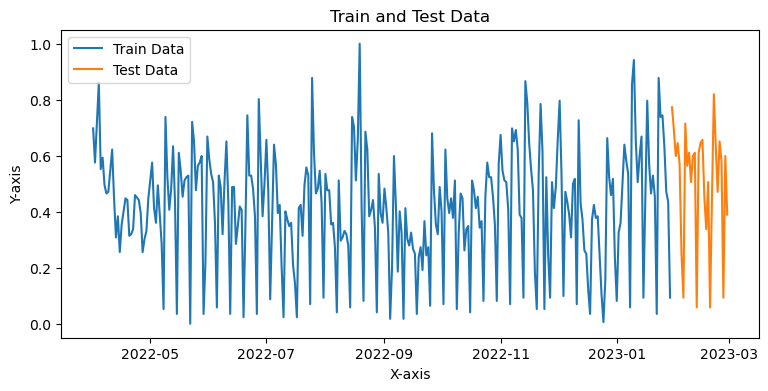

In [67]:
# Plotting train_df

fig=plt.subplots(figsize=(9,4))
plt.plot(train_df['ds'], train_df['y'], label='Train Data')

# Plotting test_df
plt.plot(test_df['ds'], test_df['y'], label='Test Data')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Train and Test Data')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


Creating the holidays dataframe

In [68]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime([ '2022-05-30',
                        '2022-06-20','2022-07-04', '2022-09-05',
                       '2022-10-10','2022-11-11','2022-11-24',
                       '2022-12-26','2023-01-02','2023-01-16',
                       '2023-02-20']),
  'lower_window': 0,
  'upper_window': 1,
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2023-02-17']),
  'lower_window': -7,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, superbowls))

# Prophet

Prophet without Holidays

In [69]:
#Initializing our Prophet model and fitting it with our train set
modelP= Prophet()
modelP.fit(train_df)


15:27:12 - cmdstanpy - INFO - Chain [1] start processing
15:27:12 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
#Creating the future predictions
futureP = modelP.make_future_dataframe(periods=pred_size)
forecastP =modelP.predict(futureP)

forecastP['y'] = test_df['y']

In [71]:
#Calculating the RMSE of our model
rmse_P = np.sqrt(mean_squared_error(test_df['y'], forecastP['yhat'].tail(pred_size)))
print('Root Mean Squared Error (RMSE):', rmse_P)

Root Mean Squared Error (RMSE): 0.11834505217757359


Prophet with Holidays

In [72]:
#Initializing our Prophet model and fitting it with our train set and using the holidays
modelHoliday = Prophet(holidays=holidays)
modelHoliday.add_seasonality(name='daily', period=1, fourier_order=10, prior_scale=10)
modelHoliday.add_country_holidays(country_name='US')
modelHoliday.fit(train_df)

#Creating the future predictions
future_modelHoliday = modelHoliday.make_future_dataframe(periods=pred_size, freq='D')
forecast_Holiday = modelHoliday.predict(future_modelHoliday)
forecast_Holiday['y'] = test_df['y']

15:27:12 - cmdstanpy - INFO - Chain [1] start processing
15:27:12 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
#Calculating the RMSE of our model

rmse_PH = np.sqrt(mean_squared_error(test_df['y'], forecast_Holiday['yhat'].tail(pred_size)))
print('Root Mean Squared Error (RMSE):', rmse_PH)

Root Mean Squared Error (RMSE): 0.10612588621944997


# Prophet with and without holidays

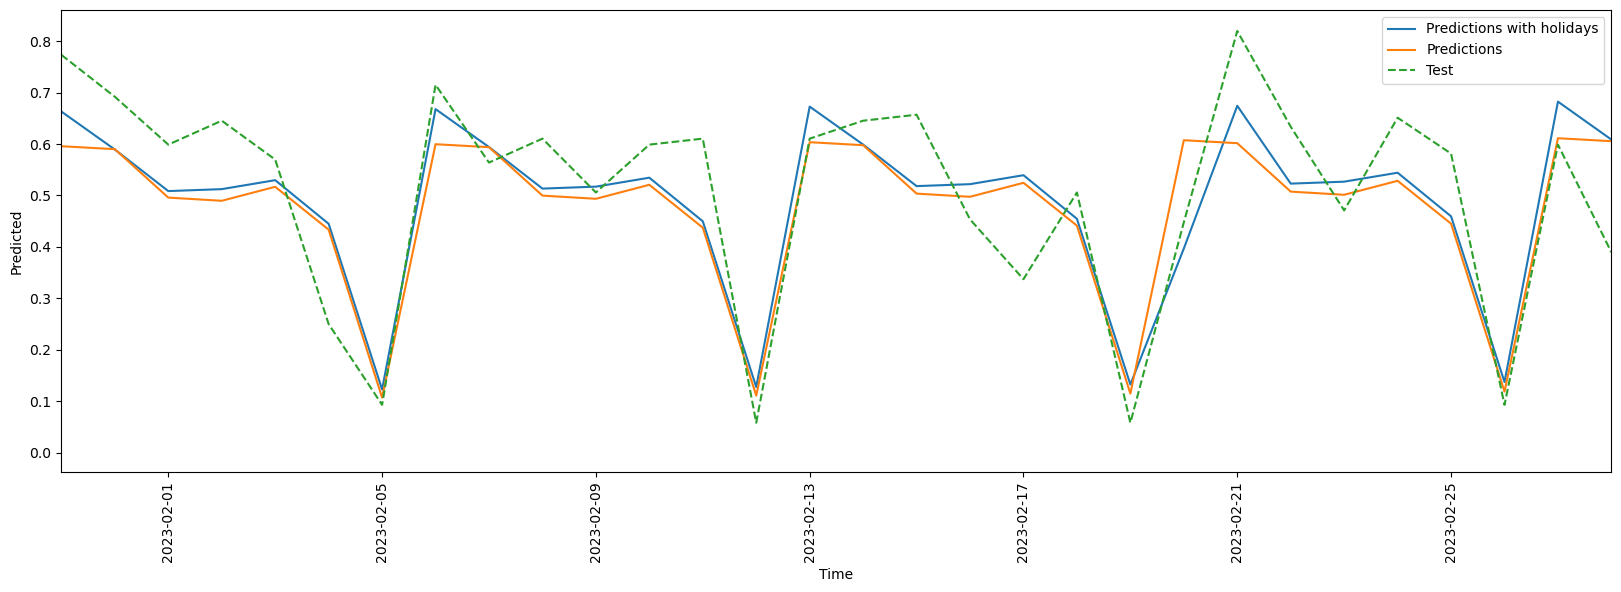

In [74]:
#Comparing our Prophet models vs the test dataframe

plt.figure(figsize=(20, 6))
sns.lineplot(data=forecast_Holiday, x='ds', y='yhat', label='Predictions with holidays')
sns.lineplot(data=forecastP, x='ds', y='yhat',  label='Predictions')
sns.lineplot(data=test_df, x='ds', y='y',  label='Test', linestyle='--')
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Predicted')
plt.xlim(test_df['ds'].min(), test_df['ds'].max()) 
plt.show()

In [75]:
# Neural Prophet

Neural Prophet with Holidays

In [76]:
#Initializing our Prophet model and fitting it with our train set and holidays

model_w_holidays = NeuralProphet(daily_seasonality=True)
model_w_holidays.add_country_holidays(country_name='USA')
model_w_holidays.fit(train_df, freq='D')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.651% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 303
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (19) is too small than the required number for the learning rate finder (214). The results might not be optimal.


Finding best initial lr:   0%|          | 0/214 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,0.874066,0.918979,0.538146,0.0,0
1,0.860454,0.904622,0.525949,0.0,1
2,0.846942,0.893818,0.512320,0.0,2
3,0.835443,0.879623,0.502659,0.0,3
4,0.815036,0.864904,0.483724,0.0,4
...,...,...,...,...,...
298,0.090510,0.117558,0.010315,0.0,298
299,0.090781,0.117089,0.010336,0.0,299
300,0.091230,0.119063,0.010455,0.0,300
301,0.091411,0.117990,0.010445,0.0,301


In [77]:
#Creating the future predictions

future_period_hol = model_w_holidays.make_future_dataframe(train_df, periods=pred_size)
forecast_np_w_hol = model_w_holidays.predict(future_period_hol)
forecast_np_w_hol.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.651% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_weekly,season_daily,events_additive,event_Christmas Day,event_Christmas Day (Observed),event_Columbus Day,...,event_Juneteenth National Independence Day (Observed),event_Labor Day,event_Martin Luther King Jr. Day,event_Memorial Day,event_New Year's Day,event_New Year's Day (Observed),event_Thanksgiving,event_Veterans Day,event_Veterans Day (Observed),event_Washington's Birthday
25,2023-02-24,None,0.556564,1.204506,0.044176,-0.692118,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,2023-02-25,None,0.465632,1.205157,-0.047407,-0.692118,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,2023-02-26,None,0.150205,1.205808,-0.363486,-0.692118,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,2023-02-27,None,0.694970,1.206459,0.180628,-0.692118,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,2023-02-28,None,0.639086,1.207111,0.124093,-0.692118,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
#Calculating the RMSE of our model
rmse_NPH = np.sqrt(mean_squared_error(test_df['y'], forecast_np_w_hol['yhat1'].tail(pred_size)))
print('Root Mean Squared Error (RMSE):', rmse_NPH)

Root Mean Squared Error (RMSE): 0.10832484759550083


Neural Prophet without holidays

In [79]:
#Initializing our Prophet model and fitting it with our train set and holidays

model_np = NeuralProphet(daily_seasonality=True)
model_np.fit(train_df, freq='D')


#Creating the future predictions
future_period = model_np.make_future_dataframe(train_df, periods=pred_size)
forecast_np = model_np.predict(future_period)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.651% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 303
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (19) is too small than the required number for the learning rate finder (214). The results might not be optimal.


Finding best initial lr:   0%|          | 0/214 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.651% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 19it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [80]:
#Calculating the RMSE of our model
rmse_NP = np.sqrt(mean_squared_error(test_df['y'], forecast_np['yhat1'].tail(pred_size)))
print('Root Mean Squared Error (RMSE):', rmse_NP)

Root Mean Squared Error (RMSE): 0.1152590327636554


# Neural Prophet with and without holidays

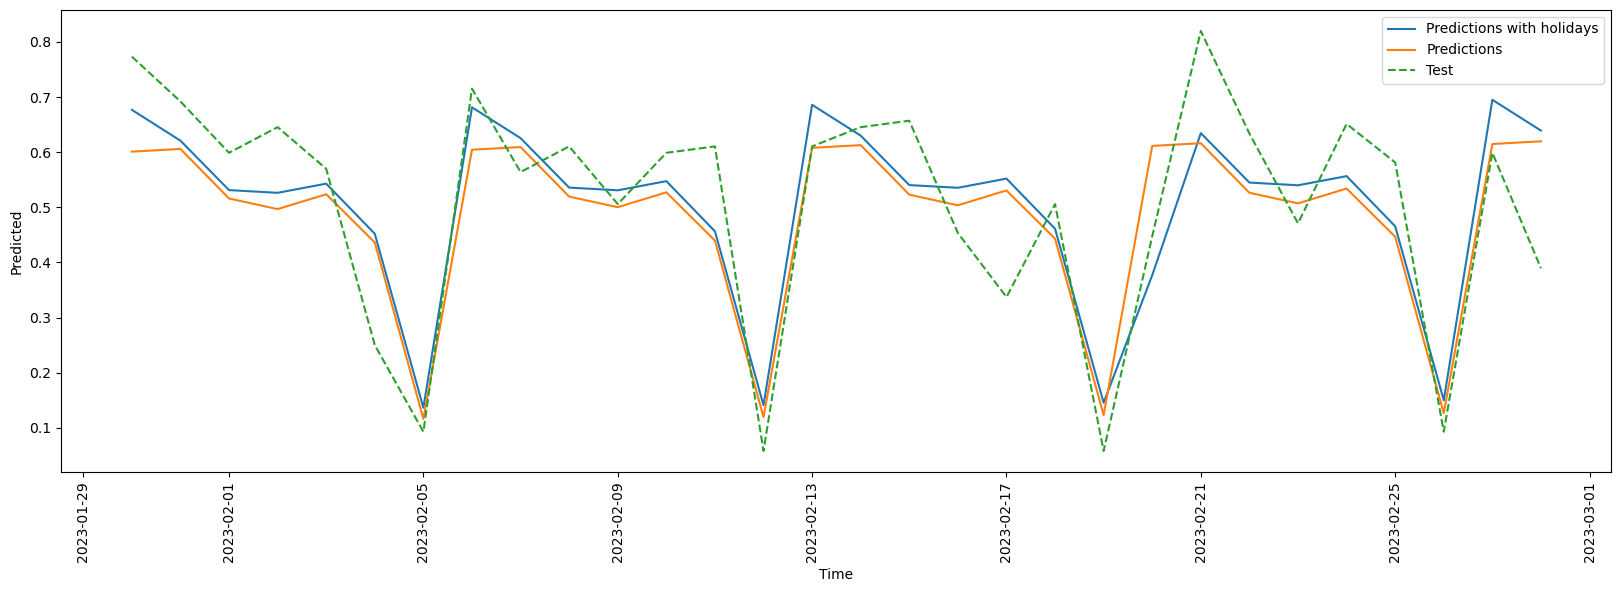

In [81]:
#Comparing our NueralProphet models vs the test dataframe

plt.figure(figsize=(20, 6))
sns.lineplot(data=forecast_np_w_hol, x='ds', y='yhat1', label='Predictions with holidays')
sns.lineplot(data=forecast_np, x='ds', y='yhat1',  label='Predictions')
sns.lineplot(data=test_df, x='ds', y='y',  label='Test',linestyle='--')
plt.xticks(rotation=90)

plt.xlabel('Time')
plt.ylabel('Predicted')
plt.show()

# Metrics

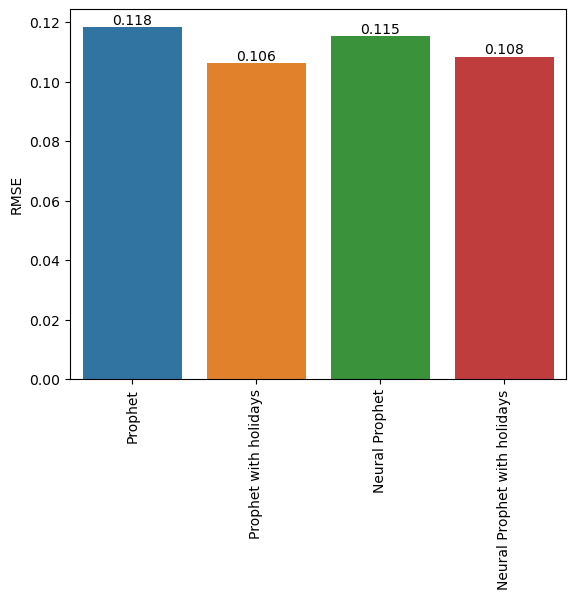

In [86]:
categories = ['Prophet', 'Prophet with holidays', 'Neural Prophet', 'Neural Prophet with holidays']
values = [rmse_P, rmse_PH, rmse_NP, rmse_NPH]
sns.barplot(x=categories, y=values)
plt.xticks(rotation=90)
plt.ylabel('RMSE')


# Add datalabels
for i, v in enumerate(values):
    plt.annotate(str(round(v, 3)), xy=(i, v), ha='center', va='bottom')

plt.show()
                     